# Droplet spreading over a flat surface against static contact angle $\theta_e$ -         Mesh convergence study
![Droplet_Spreading domain configuration](DropletSpreading.png)

For this case study, we have considered a droplet spreading on a flat surface ([dupont2010numerical](https://doi.org/10.1016/j.jcp.2009.07.034)) that allows for studying the effect of the static contact angle boundary condition and the Bond number, $Bo = \frac{\rho_l g R_0}{\sigma}$ on the equilibrium shape of the droplet. Ideally, for a droplet that spreads with $Bo\ll1$, surface tension forces dominate, and the droplet at equilibrium maintains a spherical cap shape and satisfies the contact angle boundary condition. On the other hand, for $Bo\gg1$, the gravitational forces dominate, and the droplet forms a puddle, whose height is directly proportional to the capillary length, $l_{Ca}=\sqrt{\frac{\sigma}{\rho_l g}}$. The conservation of the droplet’s volume $V$ with an equilibrium contact angle $\theta_e$ allows formulating the geometrical relations that define the equilibrium shape of the droplet ([dupont2010numerical](https://doi.org/10.1016/j.jcp.2009.07.034), [fricke2020geometry](https://arxiv.org/abs/2003.04914)). In addition to observing droplets at equilibrium, we have also studied the mesh convergence of the spreading droplets.

This notebook shows the droplet spreading in the absence of gravity against a range of static contact angles $\theta_e$

#### Note: water_glycerol and water are labelled as 'wg' and 'w' respectively.



# heightFunction

Droplet Volume = 4.5238934211693007e-10
modules path:  /work/scratch/ma11kuba/perfectWetting/perfWettingFiner/../../modules
Contact angles:  [3, 5, 7, 10]
Variant's list:  ['0', '1', '2', '3']


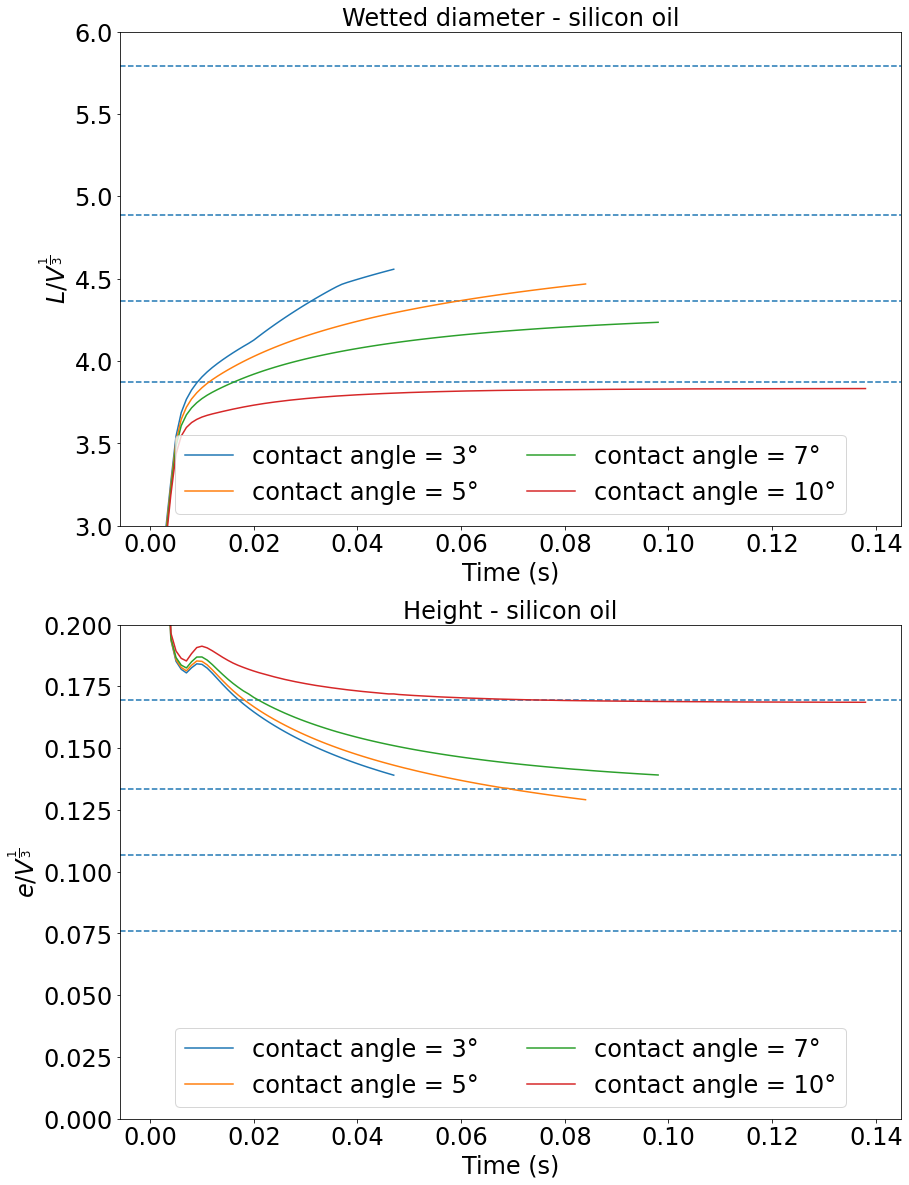

In [1]:
#Loading the necessary files
import pandas as pd
import numpy as np
from vtk import vtkStructuredPointsReader
from vtk.util import numpy_support as VN
import csv
import sys
# for radians
import math
import os
import matplotlib.pyplot as plt
import re
import itertools
import ast
from matplotlib import rcParams
pi =np.pi
sin = np.sin
cos = np.cos
dpi =800
fontSize =24


fluids = ['5e-06'] #kinematic viscosity for the silicion oil #Add other fluid values in this array for their plots
surfaceTensionModel = 'heightFunction' #surface tension model chosen for the simulations {heightFunction, RDF, fitParaboloid}
dataFolder = '/postProcessing/' #folder with .csv files
calcHeights = True #True is new simulation is run and height.csv file is needed to be updated from vtk files
dropletRadius = 0.0006 #R0
dropletVolume = 4/(2*3) * pi * dropletRadius**(3) #2 is because of semi-sphere, remove it for a full sphere
print('Droplet Volume = ' + str(dropletVolume) )

sys.path.append(os.path.join(os.getcwd(), '../modules'))
print('modules path: ', os.path.join(os.getcwd(), '../modules'))
from flat_spreading_funcs import Funcs

#######################################################################################
#Reference solutions
def getDiaHeight(SCA_List):
    L_List = [None] * len(SCA_List) ##spread analytical -> wetted diameter
    e_List = [None] * len(SCA_List) #analytical height
    for i, val in enumerate(SCA_List):
       # print(SCA_List[i], dropletVolume)
        theta = math.radians(SCA_List[i]) 
        L_List[i] = Funcs.getAnalyticalWettedRadiusByVolume(theta,dropletVolume)[0] *2/(dropletVolume**(1/3)) #non-dimensional
        e_List[i] = Funcs.getAnalyticalWettedRadiusByVolume(theta,dropletVolume)[1] /(dropletVolume**(1/3)) #non-dimensional
    return (L_List, e_List)
###############################################################################################################

#Plot equilibrium spread and height versus time

fig, axs = plt.subplots(2,1, figsize=(14, 20))
ax0 = axs[0] #wetted diameter
ax1 = axs[1] #droplet height

#############################################################################################################
wettedAreaFileNames = [] # list to stores the wetted area files to plot
vtk_folders = [] # list to store vtk files to calculate the height of the surface
heightFileNames = [] # list of file names that stores the height of the droplet
dropVol = [] # droplet volume list to store, efffective if the droplet volume is not consistent in parametric cases 

def plot(fluid):
    
    simStaticCAList= [] # static contact angles used for simulations taken from the variation file
    stm = [] # surface tension models in all cases,taken from the variation file
    var_list = [] # variance number of the parametric study of a specific case
    
    #variables for plots for silicon oil
    fluidLabel = 'NSfiner_' #parametric file labels -> NSfiner_ for perfect wetting
    fluidTitle = 'silicon oil'
    markerLabel = '^'
    
    #variables for plots for water_gylcerol
    if (fluid=='2.507e-05'):
        fluidLabel = 'NSfiner_'
        fluidTitle = 'water-gylcerol'
        markerLabel = 's'
    
    #read the variation-file to get the parameters map that is saved using pyFOAM
    var_Map = Funcs.fileMappingZeroG(fluidLabel, surfaceTensionModel)
    
     
    for key, value in var_Map.items():
        if fluid in str(value.values()): #to include the specific fluid only
            stm_map = str(value).split(', ')[3][:-1] #surface tension model map
            stm.append(stm_map.split(': ')[1][1:])
            theta_map = str(value).split(', ')[4][:-1] #contact angle map
            #print(theta_map)
            simStaticCAList.append(int(theta_map.split(': ')[1][0:]))
            var_list.append(str(key))  
    print('Contact angles: ', simStaticCAList)
    print('Variant\'s list: ', var_list)
    plotLabels = ['contact angle = '+ str(ca) + '°' for ca in simStaticCAList]
    
    L_List = [None] * len(simStaticCAList) ##spread analytical -> wetted diameter
    e_List = [None] * len(simStaticCAList) #analytical height
    L_List = getDiaHeight(simStaticCAList)[0]
    e_List = getDiaHeight(simStaticCAList)[1]

    #Reference solution plot
    [ax0.axhline(y=i, linestyle='--') for i in L_List]
    [ax1.axhline(y=i, linestyle='--') for i in e_List]

    
    #File names
    wettedAreaFileNames = Funcs.fileStructure(dataFolder, 'wettedArea.csv', fluidLabel, var_list )
    vtk_folders = Funcs.fileStructure(dataFolder, 'surfaces/', fluidLabel, var_list)
    heightFileNames = Funcs.fileStructure(dataFolder, 'height.csv', fluidLabel,var_list)
    
    #Calculates the height of the the droplet from vtk files and stores in the respective height.csv file in each simulation folder
    Funcs.writeHeightFile(calcHeights, wettedAreaFileNames, vtk_folders, heightFileNames)
    
    #Plot
    for idx, heightFile in enumerate(heightFileNames):
        lines = open (heightFileNames[idx]).readlines()
        time =[]
        height = []
        wettedDiameter = []
        for line in lines:
            time.append(float(line.rsplit(',')[0]))
            height.append((float(line.rsplit(',')[1]))/(dropletVolume**(1/3)))
        ax1.set_title('Height - '+fluidTitle, fontsize= fontSize)
        ax1.set_xlabel('Time (s)', fontsize= fontSize)
        ax1.set_ylabel(r"$e/V^\frac{1}{3}$", fontsize= fontSize)
        ax1.tick_params(axis='both', which='major', labelsize=fontSize)
        ax1.axis(ymin=0,ymax=0.2)
        ax1.plot(time, height, label=plotLabels[idx])
        ax1.legend(fontsize=fontSize, loc='lower center',ncol=2)
        
        lines = open (wettedAreaFileNames[idx]).readlines()
        for line in lines:
            wettedDiameter.append((2*0.001*(((float(line.rsplit(',')[1]))/pi)**(1/2)))/(dropletVolume**(1/3)))
        ax0.set_title('Wetted diameter - '+fluidTitle, fontsize= fontSize)
        ax0.set_xlabel('Time (s)', fontsize= fontSize)
        ax0.set_ylabel(r"$L/V^\frac{1}{3}$", fontsize= fontSize)
        ax0.tick_params(axis='both', which='major', labelsize=fontSize)
        ax0.axis(ymin=3.0,ymax=6.0)
        ax0.plot(time, wettedDiameter, label=plotLabels[idx])
        ax0.legend(fontsize=fontSize, loc='lower center',ncol=2)
#     
    
############################################################################################################

for fluid in fluids:
    plot(fluid)
#print(heightFileNames)
    
#plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.5, -.48), ncol=2)
#plt.savefig('droplet-chractersitics-against-static-contact-angle'+'.png', bbox_inches='tight')
#plt.savefig('droplet-chractersitics-against-static-contact-angle'+'.pdf', bbox_inches='tight')
#plt.show()




# RDF

Droplet Volume = 4.5238934211693007e-10
modules path:  /work/scratch/ma11kuba/perfectWetting/perfWettingFiner/../../modules
Contact angles:  [3, 5, 7, 10]
Variant's list:  ['4', '5', '6', '7']


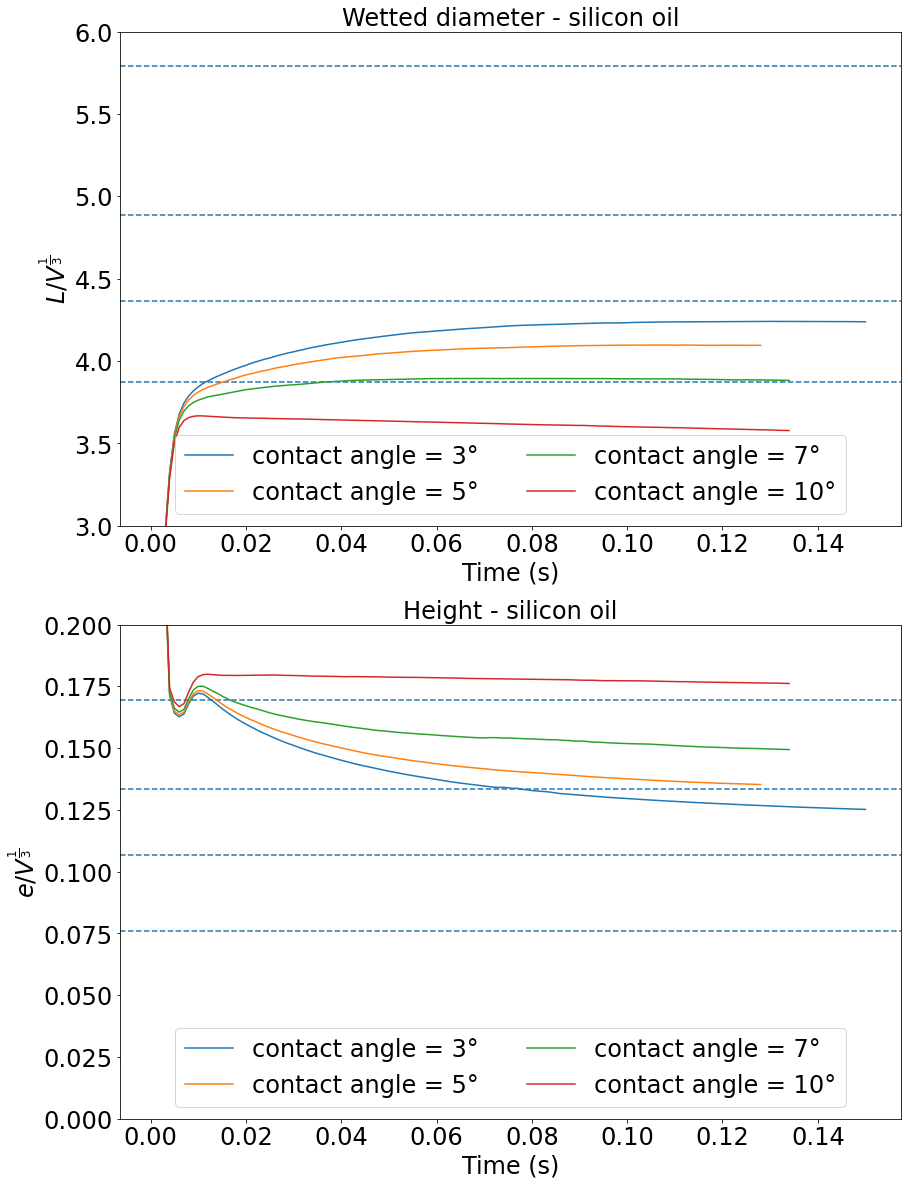

In [2]:
#Loading the necessary files
import pandas as pd
import numpy as np
from vtk import vtkStructuredPointsReader
from vtk.util import numpy_support as VN
import csv
import sys
# for radians
import math
import os
import matplotlib.pyplot as plt
import re
import itertools
import ast
from matplotlib import rcParams
pi =np.pi
sin = np.sin
cos = np.cos
dpi =800
fontSize =24


fluids = ['5e-06'] #kinematic viscosity for the silicion oil #Add other fluid values in this array for their plots
surfaceTensionModel = 'RDF' #surface tension model chosen for the simulations {heightFunction, RDF, fitParaboloid}
dataFolder = '/postProcessing/' #folder with .csv files
calcHeights = True #True is new simulation is run and height.csv file is needed to be updated from vtk files
dropletRadius = 0.0006 #R0
dropletVolume = 4/(2*3) * pi * dropletRadius**(3) #2 is because of semi-sphere, remove it for a full sphere
print('Droplet Volume = ' + str(dropletVolume) )

sys.path.append(os.path.join(os.getcwd(), '../modules'))
print('modules path: ', os.path.join(os.getcwd(), '../modules'))
from flat_spreading_funcs import Funcs

#######################################################################################
#Reference solutions
def getDiaHeight(SCA_List):
    L_List = [None] * len(SCA_List) ##spread analytical -> wetted diameter
    e_List = [None] * len(SCA_List) #analytical height
    for i, val in enumerate(SCA_List):
       # print(SCA_List[i], dropletVolume)
        theta = math.radians(SCA_List[i]) 
        L_List[i] = Funcs.getAnalyticalWettedRadiusByVolume(theta,dropletVolume)[0] *2/(dropletVolume**(1/3)) #non-dimensional
        e_List[i] = Funcs.getAnalyticalWettedRadiusByVolume(theta,dropletVolume)[1] /(dropletVolume**(1/3)) #non-dimensional
    return (L_List, e_List)
###############################################################################################################

#Plot equilibrium spread and height versus time

fig, axs = plt.subplots(2,1, figsize=(14, 20))
ax0 = axs[0] #wetted diameter
ax1 = axs[1] #droplet height

#############################################################################################################
wettedAreaFileNames = [] # list to stores the wetted area files to plot
vtk_folders = [] # list to store vtk files to calculate the height of the surface
heightFileNames = [] # list of file names that stores the height of the droplet
dropVol = [] # droplet volume list to store, efffective if the droplet volume is not consistent in parametric cases 

def plot(fluid):
    
    simStaticCAList= [] # static contact angles used for simulations taken from the variation file
    stm = [] # surface tension models in all cases,taken from the variation file
    var_list = [] # variance number of the parametric study of a specific case
    
    #variables for plots for silicon oil
    fluidLabel = 'NSfiner_' #parametric file labels -> NSfiner_ for perfect wetting
    fluidTitle = 'silicon oil'
    markerLabel = '^'
    
    #variables for plots for water_gylcerol
    if (fluid=='2.507e-05'):
        fluidLabel = 'NSfiner_'
        fluidTitle = 'water-gylcerol'
        markerLabel = 's'
    
    #read the variation-file to get the parameters map that is saved using pyFOAM
    var_Map = Funcs.fileMappingZeroG(fluidLabel, surfaceTensionModel)
    
     
    for key, value in var_Map.items():
        if fluid in str(value.values()): #to include the specific fluid only
            stm_map = str(value).split(', ')[3][:-1] #surface tension model map
            stm.append(stm_map.split(': ')[1][1:])
            theta_map = str(value).split(', ')[4][:-1] #contact angle map
            #print(theta_map)
            simStaticCAList.append(int(theta_map.split(': ')[1][0:]))
            var_list.append(str(key))  
    print('Contact angles: ', simStaticCAList)
    print('Variant\'s list: ', var_list)
    plotLabels = ['contact angle = '+ str(ca) + '°' for ca in simStaticCAList]
    
    L_List = [None] * len(simStaticCAList) ##spread analytical -> wetted diameter
    e_List = [None] * len(simStaticCAList) #analytical height
    L_List = getDiaHeight(simStaticCAList)[0]
    e_List = getDiaHeight(simStaticCAList)[1]

    #Reference solution plot
    [ax0.axhline(y=i, linestyle='--') for i in L_List]
    [ax1.axhline(y=i, linestyle='--') for i in e_List]

    
    #File names
    wettedAreaFileNames = Funcs.fileStructure(dataFolder, 'wettedArea.csv', fluidLabel, var_list )
    vtk_folders = Funcs.fileStructure(dataFolder, 'surfaces/', fluidLabel, var_list)
    heightFileNames = Funcs.fileStructure(dataFolder, 'height.csv', fluidLabel,var_list)
    
    #Calculates the height of the the droplet from vtk files and stores in the respective height.csv file in each simulation folder
    Funcs.writeHeightFile(calcHeights, wettedAreaFileNames, vtk_folders, heightFileNames)
    
    #Plot
    for idx, heightFile in enumerate(heightFileNames):
        lines = open (heightFileNames[idx]).readlines()
        time =[]
        height = []
        wettedDiameter = []
        for line in lines:
            time.append(float(line.rsplit(',')[0]))
            height.append((float(line.rsplit(',')[1]))/(dropletVolume**(1/3)))
        ax1.set_title('Height - '+fluidTitle, fontsize= fontSize)
        ax1.set_xlabel('Time (s)', fontsize= fontSize)
        ax1.set_ylabel(r"$e/V^\frac{1}{3}$", fontsize= fontSize)
        ax1.tick_params(axis='both', which='major', labelsize=fontSize)
        ax1.axis(ymin=0,ymax=0.2)
        ax1.plot(time, height, label=plotLabels[idx])
        ax1.legend(fontsize=fontSize, loc='lower center',ncol=2)
        
        lines = open (wettedAreaFileNames[idx]).readlines()
        for line in lines:
            wettedDiameter.append((2*0.001*(((float(line.rsplit(',')[1]))/pi)**(1/2)))/(dropletVolume**(1/3)))
        ax0.set_title('Wetted diameter - '+fluidTitle, fontsize= fontSize)
        ax0.set_xlabel('Time (s)', fontsize= fontSize)
        ax0.set_ylabel(r"$L/V^\frac{1}{3}$", fontsize= fontSize)
        ax0.tick_params(axis='both', which='major', labelsize=fontSize)
        ax0.axis(ymin=3.0,ymax=6.0)
        ax0.plot(time, wettedDiameter, label=plotLabels[idx])
        ax0.legend(fontsize=fontSize, loc='lower center',ncol=2)
#     
    
############################################################################################################

for fluid in fluids:
    plot(fluid)
#print(heightFileNames)
    
#plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.5, -.48), ncol=2)
#plt.savefig('droplet-chractersitics-against-static-contact-angle'+'.png', bbox_inches='tight')
#plt.savefig('droplet-chractersitics-against-static-contact-angle'+'.pdf', bbox_inches='tight')
#plt.show()




# fitParaboloid

Droplet Volume = 4.5238934211693007e-10
modules path:  /work/scratch/ma11kuba/perfectWetting/perfWettingFiner/../../modules
Contact angles:  [3, 5, 7, 10]
Variant's list:  ['8', '9', '10', '11']


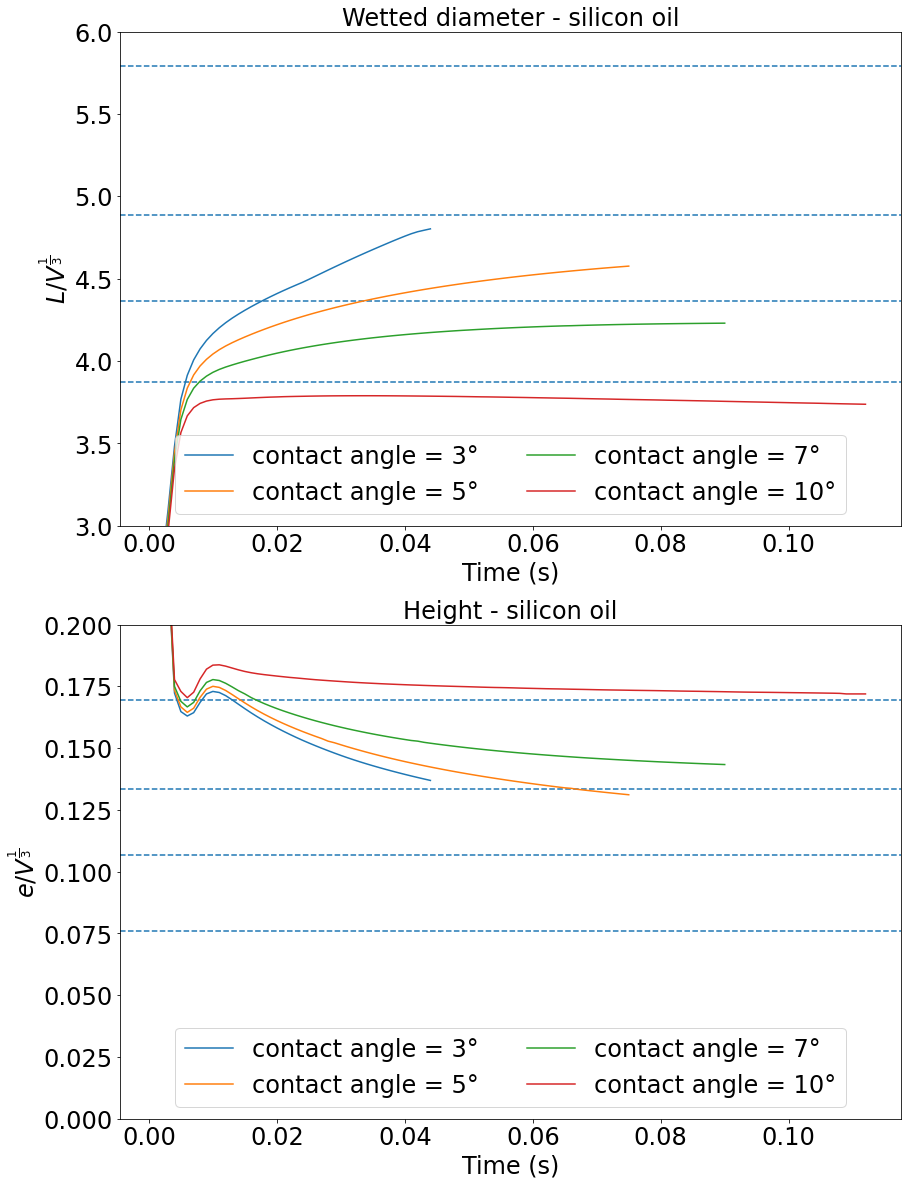

In [3]:
#Loading the necessary files
import pandas as pd
import numpy as np
from vtk import vtkStructuredPointsReader
from vtk.util import numpy_support as VN
import csv
import sys
# for radians
import math
import os
import matplotlib.pyplot as plt
import re
import itertools
import ast
from matplotlib import rcParams
pi =np.pi
sin = np.sin
cos = np.cos
dpi =800
fontSize =24


fluids = ['5e-06'] #kinematic viscosity for the silicion oil #Add other fluid values in this array for their plots
surfaceTensionModel = 'fitParaboloid' #surface tension model chosen for the simulations {heightFunction, RDF, fitParaboloid}
dataFolder = '/postProcessing/' #folder with .csv files
calcHeights = True #True is new simulation is run and height.csv file is needed to be updated from vtk files
dropletRadius = 0.0006 #R0
dropletVolume = 4/(2*3) * pi * dropletRadius**(3) #2 is because of semi-sphere, remove it for a full sphere
print('Droplet Volume = ' + str(dropletVolume) )

sys.path.append(os.path.join(os.getcwd(), '../modules'))
print('modules path: ', os.path.join(os.getcwd(), '../modules'))
from flat_spreading_funcs import Funcs

#######################################################################################
#Reference solutions
def getDiaHeight(SCA_List):
    L_List = [None] * len(SCA_List) ##spread analytical -> wetted diameter
    e_List = [None] * len(SCA_List) #analytical height
    for i, val in enumerate(SCA_List):
       # print(SCA_List[i], dropletVolume)
        theta = math.radians(SCA_List[i]) 
        L_List[i] = Funcs.getAnalyticalWettedRadiusByVolume(theta,dropletVolume)[0] *2/(dropletVolume**(1/3)) #non-dimensional
        e_List[i] = Funcs.getAnalyticalWettedRadiusByVolume(theta,dropletVolume)[1] /(dropletVolume**(1/3)) #non-dimensional
    return (L_List, e_List)
###############################################################################################################

#Plot equilibrium spread and height versus time

fig, axs = plt.subplots(2,1, figsize=(14, 20))
ax0 = axs[0] #wetted diameter
ax1 = axs[1] #droplet height

#############################################################################################################
wettedAreaFileNames = [] # list to stores the wetted area files to plot
vtk_folders = [] # list to store vtk files to calculate the height of the surface
heightFileNames = [] # list of file names that stores the height of the droplet
dropVol = [] # droplet volume list to store, efffective if the droplet volume is not consistent in parametric cases 

def plot(fluid):
    
    simStaticCAList= [] # static contact angles used for simulations taken from the variation file
    stm = [] # surface tension models in all cases,taken from the variation file
    var_list = [] # variance number of the parametric study of a specific case
    
    #variables for plots for silicon oil
    fluidLabel = 'NSfiner_' #parametric file labels -> NSfiner_ for perfect wetting
    fluidTitle = 'silicon oil'
    markerLabel = '^'
    
    #variables for plots for water_gylcerol
    if (fluid=='2.507e-05'):
        fluidLabel = 'NSfiner_'
        fluidTitle = 'water-gylcerol'
        markerLabel = 's'
    
    #read the variation-file to get the parameters map that is saved using pyFOAM
    var_Map = Funcs.fileMappingZeroG(fluidLabel, surfaceTensionModel)
    
     
    for key, value in var_Map.items():
        if fluid in str(value.values()): #to include the specific fluid only
            stm_map = str(value).split(', ')[3][:-1] #surface tension model map
            stm.append(stm_map.split(': ')[1][1:])
            theta_map = str(value).split(', ')[4][:-1] #contact angle map
            #print(theta_map)
            simStaticCAList.append(int(theta_map.split(': ')[1][0:]))
            var_list.append(str(key))  
    print('Contact angles: ', simStaticCAList)
    print('Variant\'s list: ', var_list)
    plotLabels = ['contact angle = '+ str(ca) + '°' for ca in simStaticCAList]
    
    L_List = [None] * len(simStaticCAList) ##spread analytical -> wetted diameter
    e_List = [None] * len(simStaticCAList) #analytical height
    L_List = getDiaHeight(simStaticCAList)[0]
    e_List = getDiaHeight(simStaticCAList)[1]

    #Reference solution plot
    [ax0.axhline(y=i, linestyle='--') for i in L_List]
    [ax1.axhline(y=i, linestyle='--') for i in e_List]

    
    #File names
    wettedAreaFileNames = Funcs.fileStructure(dataFolder, 'wettedArea.csv', fluidLabel, var_list )
    vtk_folders = Funcs.fileStructure(dataFolder, 'surfaces/', fluidLabel, var_list)
    heightFileNames = Funcs.fileStructure(dataFolder, 'height.csv', fluidLabel,var_list)
    
    #Calculates the height of the the droplet from vtk files and stores in the respective height.csv file in each simulation folder
    Funcs.writeHeightFile(calcHeights, wettedAreaFileNames, vtk_folders, heightFileNames)
    
    #Plot
    for idx, heightFile in enumerate(heightFileNames):
        lines = open (heightFileNames[idx]).readlines()
        time =[]
        height = []
        wettedDiameter = []
        for line in lines:
            time.append(float(line.rsplit(',')[0]))
            height.append((float(line.rsplit(',')[1]))/(dropletVolume**(1/3)))
        ax1.set_title('Height - '+fluidTitle, fontsize= fontSize)
        ax1.set_xlabel('Time (s)', fontsize= fontSize)
        ax1.set_ylabel(r"$e/V^\frac{1}{3}$", fontsize= fontSize)
        ax1.tick_params(axis='both', which='major', labelsize=fontSize)
        ax1.axis(ymin=0,ymax=0.2)
        ax1.plot(time, height, label=plotLabels[idx])
        ax1.legend(fontsize=fontSize, loc='lower center',ncol=2)
        
        lines = open (wettedAreaFileNames[idx]).readlines()
        for line in lines:
            wettedDiameter.append((2*0.001*(((float(line.rsplit(',')[1]))/pi)**(1/2)))/(dropletVolume**(1/3)))
        ax0.set_title('Wetted diameter - '+fluidTitle, fontsize= fontSize)
        ax0.set_xlabel('Time (s)', fontsize= fontSize)
        ax0.set_ylabel(r"$L/V^\frac{1}{3}$", fontsize= fontSize)
        ax0.tick_params(axis='both', which='major', labelsize=fontSize)
        ax0.axis(ymin=3.0,ymax=6.0)
        ax0.plot(time, wettedDiameter, label=plotLabels[idx])
        ax0.legend(fontsize=fontSize, loc='lower center',ncol=2)
#     
    
############################################################################################################

for fluid in fluids:
    plot(fluid)
#print(heightFileNames)
    
#plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.5, -.48), ncol=2)
#plt.savefig('droplet-chractersitics-against-static-contact-angle'+'.png', bbox_inches='tight')
#plt.savefig('droplet-chractersitics-against-static-contact-angle'+'.pdf', bbox_inches='tight')
#plt.show()


